In [1]:
import pandas as pd
import numpy as np
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math 
import seaborn as sns
import matplotlib.colors as mcolors
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.formula.api import mixedlm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os
import matplotlib.pyplot as mpl
import matplotlib

colors = list(mcolors.TABLEAU_COLORS.keys())*2

parentDirectory = os.path.abspath(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir))
DATA_DIR = parentDirectory +'/data/'
FIGURES_DIR = parentDirectory +'/figures/'

full_names = {
    'AU': 'Australia',
    'BR': 'Brazil',
    'CA': 'Canada',
    'FR': 'France',
    'DE': 'Germany',
    'IN': 'India',
    'IT': 'Italy',
    'MX': 'Mexico',
    'ES': 'Spain',
    'GB': 'United Kingdom',
    'US': 'United States',
    'DK': 'Denmark'
}

event_dicts = [{'country': 'AU',
  'start_md_1': '2020-03-27',
  'end_md_1': '2020-06-07',
  'start_md_2': np.nan},
 {'country': 'BR',
  'start_md_1': '2020-03-23',
  'end_md_1': '2020-08-09',
  'start_md_2': np.nan},
 {'country': 'CA',
  'start_md_1': '2020-03-19',
  'end_md_1': '2020-06-21',
  'start_md_2': '2020-10-12'},
 {'country': 'DE',
  'start_md_1': '2020-03-21',
  'end_md_1': '2020-05-09',
  'start_md_2': '2020-12-18'},
 {'country': 'DK',
  'start_md_1': '2020-03-17',
  'end_md_1': '2020-05-07',
  'start_md_2': np.nan},
 {'country': 'ES',
  'start_md_1': '2020-03-17',
  'end_md_1': '2020-06-14',
  'start_md_2': '2020-11-07'},
 {'country': 'FR',
  'start_md_1': '2020-03-18',
  'end_md_1': '2020-06-08',
  'start_md_2': '2020-11-01'},
 {'country': 'GB',
  'start_md_1': '2020-03-23',
  'end_md_1': '2020-08-03',
  'start_md_2': '2020-10-21'},
 {'country': 'IN',
  'start_md_1': '2020-03-24',
  'end_md_1': '2020-10-29',
  'start_md_2': np.nan},
 {'country': 'IT',
  'start_md_1': '2020-03-11',
  'end_md_1': '2020-06-06',
  'start_md_2': '2020-11-06'},
 {'country': 'JP',
  'start_md_1': '2020-04-12',
  'end_md_1': '2020-05-30',
  'start_md_2': np.nan},
 {'country': 'KE',
  'start_md_1': '2020-03-24',
  'end_md_1': '2020-10-04',
  'start_md_2': np.nan},
 {'country': 'MX',
  'start_md_1': '2020-03-25',
  'end_md_1': '2020-10-06',
  'start_md_2': np.nan},
 {'country': 'NG',
  'start_md_1': '2020-03-27',
  'end_md_1': '2020-08-09',
  'start_md_2': np.nan},
 {'country': 'US',
  'start_md_1': '2020-03-21',
  'end_md_1': '2020-06-11',
  'start_md_2': '2020-11-26'}]

df_events = pd.DataFrame(event_dicts)

df_events['start_md_1'] = pd.to_datetime(df_events['start_md_1'])
df_events['end_md_1'] = pd.to_datetime(df_events['end_md_1'])
df_events['start_md_2'] = pd.to_datetime(df_events['start_md_2'])

df_agg = pd.read_pickle(DATA_DIR+'df_agg_cats.pickle')

In [2]:
#helpers

def generate_equation(order):
    if order == 'Cubic':
        eq = "volume_total ~ intervention_flag*k*year + intervention_flag*np.power(k,2)*year + intervention_flag*np.power(k,3)*year"
    elif order == "Quadratic":
        eq = "volume_total ~ intervention_flag*k*year + intervention_flag*np.power(k,2)*year"
    elif order == "Linear":
        eq = "volume_total ~ intervention_flag*k*year"
    elif order == 'Constant':
        eq = "volume_total ~ intervention_flag*year"
    return eq

def generate_equation_interactions(order):
    if order == 'Cubic':
        eq = "volume_total ~ intervention_flag*k*year*C(country)*C(category) + intervention_flag*np.power(k,2)*year*C(country)*C(category) + intervention_flag*np.power(k,3)*year*C(country)*C(category)"
    elif order == "Quadratic":
        eq = "volume_total ~ intervention_flag*k*year*C(country)*C(category) + intervention_flag*np.power(k,2)*year*C(country)*C(category)"
    elif order == "Linear":
        eq = "volume_total ~ intervention_flag*k*year*C(country)*C(category)"
    elif order == 'Constant':
        eq = "volume_total ~ intervention_flag*year*C(country)*C(category)"
    return eq
    
def get_standard_error_sum(covariates):
    '''
    #95CI is approximated with +- 2 sum_variance_standard_error
    '''
    
    #get the variance covariance matrix
    vcov = result_interactions.cov_params()\
        .loc[covariates,covariates].values
    
    #calculate the sum of all pair wise covariances by summing up
    m_sum = np.sum(vcov)
    
    #variance of a sum of variables is the square root
    return np.sqrt((m_sum))

def make_stars(val):
    if val<0.0001:
        return '****'
    elif val<0.001:
        return '***'
    elif val<0.01:
        return '**'
    elif val<0.05:
        return '*'
    else:
        return ''

def make_star_ste(value,ste):
    if value>0 and value-2*ste>0:
        return '*'
    elif value<0 and value+2*ste<0:
        return '*'
    else:
        return ''

In [3]:
weeks_2019 = list(df_agg.iloc[0]['volume_weekly_total'].index)[:52]
weeks_2020 = list(df_agg.iloc[0]['volume_weekly_total'].index)[52:]

In [4]:
l = []
for cnt, row in df_agg.iterrows():
    start_md = df_events.loc[df_events['country'] == row['country']].iloc[0]['start_md_1']
    end_md = df_events.loc[df_events['country'] == row['country']].iloc[0]['end_md_1']
    start_md2 = df_events.loc[df_events['country'] == row['country']].iloc[0]['start_md_2']
    
    for week in zip(row['volume_weekly_total'].index,row['volume_weekly_total'].values,row['volume_percent_weekly_total'].values):
        
        entry = {}

        entry['country'] = row['country']
        entry['category'] = row['category']
        

        if week[0] in weeks_2020:
            date = pd.to_datetime(week[0])

            if type(start_md2)!=pd._libs.tslibs.nattype.NaTType and date > start_md2:
                continue

            entry['k'] = math.floor(((date - start_md).days +7) / 7)
            entry['volume_total'] = week[1]
            entry['volume_percent'] = week[2]
            entry['year'] = '2020'
            l.append(entry)

        elif week[0] in weeks_2019:
            date = pd.to_datetime(weeks_2020[weeks_2019.index(week[0])])
            
            if type(start_md2)!=pd._libs.tslibs.nattype.NaTType and date > start_md2:
                continue

            entry['k'] = math.floor(((date - start_md).days +7) / 7)
            entry['volume_total'] = week[1]
            entry['volume_percent'] = week[2]
            entry['year'] = '2019'
            l.append(entry)

df = pd.DataFrame(l)      

In [5]:
df.groupby('country').agg('k').max()

country
AU    40
BR    40
CA    30
DE    39
DK    41
ES    33
FR    33
GB    30
IN    40
IT    34
JP    38
KE    40
MX    40
NG    40
US    36
Name: k, dtype: int64

In [6]:
df.groupby('country').agg('k').min()

country
AU   -11
BR   -11
CA   -10
DE   -10
DK   -10
ES   -10
FR   -10
GB   -11
IN   -11
IT    -9
JP   -13
KE   -11
MX   -11
NG   -11
US   -10
Name: k, dtype: int64

In [7]:
df = df.loc[(df['k'] >= -30) & (df['k'] <= 30)]
df = df.loc[(df['country'].isin(list(full_names.keys())))]
df['intervention_flag'] = df['k'].apply(lambda x: 1 if x >= 0 else 0)

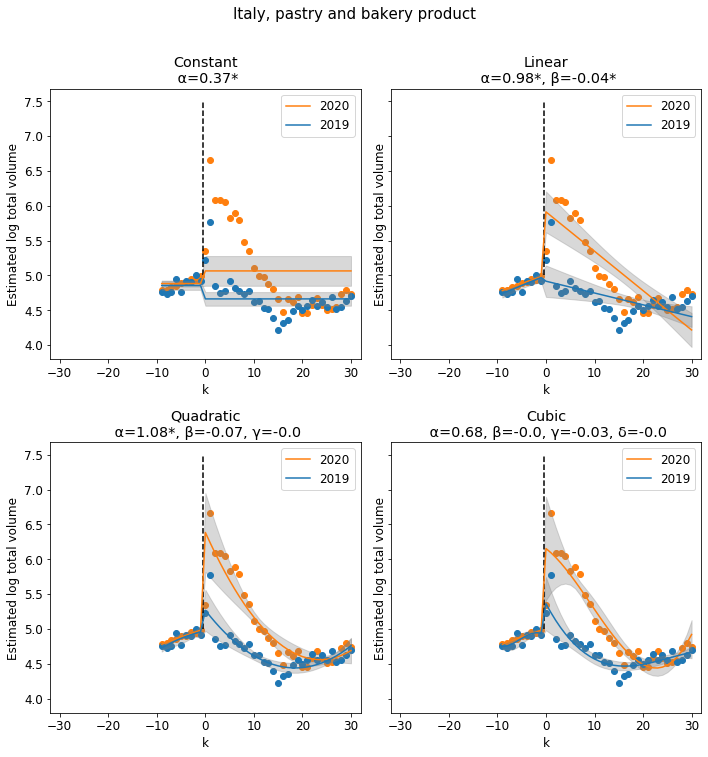

In [8]:
mpl.rcParams['font.size'] = 12
fig, axes = plt.subplots(2,2, figsize = (10,10), sharey = True)
country = 'IT'

for model in ['Constant','Linear','Quadratic','Cubic']:
    
    point = []
    conf = []
        
    k = 30
    
    df_temp = df.loc[(df['category'] == 'pastry and bakery product') & 
                                (df['country'] == country) & \
                                (df['k'] >= -k) & (df['k'] <= k)].copy()

    df_temp['volume_total'] = df_temp['volume_total'].apply(np.log)

    mod = smf.ols(generate_equation(model), 
                  data = df_temp)

    res = mod.fit(cov_type='hc0')
 
    if model == 'Constant':
        sbplt = axes[0,0]
        sbplt.set_title(model+'\n α='+str(round(res.params['intervention_flag:year[T.2020]'],2))+'*' if res.pvalues['intervention_flag:year[T.2020]']<0.05 else '')
        
    elif model == 'Linear':
        sbplt = axes[0,1]
        sbplt.set_title(model+'\n α='+str(round(res.params['intervention_flag:year[T.2020]'],2))+('*' if res.pvalues['intervention_flag:year[T.2020]']<0.05 else '') +
                        ', β='+str(round(res.params['intervention_flag:k:year[T.2020]'],2)) + ('*' if res.pvalues['intervention_flag:k:year[T.2020]']<0.05 else '') )

    elif model == 'Quadratic':
        sbplt = axes[1,0]
        sbplt.set_title(model+'\n α='+str(round(res.params['intervention_flag:year[T.2020]'],2))+('*' if res.pvalues['intervention_flag:year[T.2020]']<0.05 else '')+ 
                        ', β='+str(round(res.params['intervention_flag:k:year[T.2020]'],2)) + ('*' if res.pvalues['intervention_flag:k:year[T.2020]']<0.05 else '')+
                        ', γ='+str(round(res.params['intervention_flag:np.power(k, 2):year[T.2020]'],2)) + ('*' if res.pvalues['intervention_flag:np.power(k, 2):year[T.2020]']<0.05 else ''))

    else:
        sbplt = axes[1,1]
        sbplt.set_title(model+'\n α='+str(round(res.params['intervention_flag:year[T.2020]'],2))+('*' if res.pvalues['intervention_flag:year[T.2020]']<0.05 else '')+ 
                        ', β='+str(round(res.params['intervention_flag:k:year[T.2020]'],2)) + ('*' if res.pvalues['intervention_flag:k:year[T.2020]']<0.05 else '') +
                        ', γ='+str(round(res.params['intervention_flag:np.power(k, 2):year[T.2020]'],2)) + ('*' if res.pvalues['intervention_flag:np.power(k, 2):year[T.2020]']<0.05 else '') +
                        ', δ='+str(round(res.params['intervention_flag:np.power(k, 3):year[T.2020]'],2)) + ('*' if res.pvalues['intervention_flag:np.power(k, 3):year[T.2020]']<0.05 else ''))

    
    sbplt.vlines(-0.5,5,7.5, linestyle = '--')

    df_temp = df.loc[(df['category'] == 'pastry and bakery product') & 
                                (df['country'] == country) & \
                                (df['k'] >= -k) & (df['k'] <= k) & (df['year'] == '2020')].copy()

    df_temp['volume_total'] = df_temp['volume_total'].apply(np.log)
    
    sbplt.scatter(df_temp['k'].values,df_temp['volume_total'].values, color = 'tab:orange')
    sbplt.fill_between(df_temp['k'].values,res.get_prediction(df_temp).conf_int()[:,0],
                 res.get_prediction(df_temp).conf_int()[:,1], alpha = 0.3, color = 'gray')

    sbplt.plot(df_temp['k'].values,res.get_prediction(df_temp).predicted_mean, color = 'tab:orange', label = '2020')

    
    
    
    df_temp = df.loc[(df['category'] == 'pastry and bakery product') & 
                                (df['country'] == country) & \
                                (df['k'] >= -k) & (df['k'] <= k) & (df['year'] == '2019')].copy()

    df_temp['volume_total'] = df_temp['volume_total'].apply(np.log)
    
    sbplt.scatter(df_temp['k'].values,df_temp['volume_total'].values, color = 'tab:blue')
    sbplt.fill_between(df_temp['k'].values,res.get_prediction(df_temp).conf_int()[:,0],
                 res.get_prediction(df_temp).conf_int()[:,1], alpha = 0.3, color = 'gray')

    sbplt.plot(df_temp['k'].values,res.get_prediction(df_temp).predicted_mean, color = 'tab:blue', label = '2019')


    sbplt.legend()

    sbplt.set_xlabel('k')

    sbplt.set_xlim([-32,32])
    #sbplt.set_xlabel('Bandwidth (± weeks around intervention)')
    sbplt.set_ylabel('Estimated log total volume')
    #sbplt.set_ylim([-1.5,2.5])

plt.tight_layout()

fig.suptitle('Italy, pastry and bakery product', position = (0.5,1.05), fontsize= 15)

plt.savefig(FIGURES_DIR+"example_italy_bread.pdf", bbox_inches='tight')

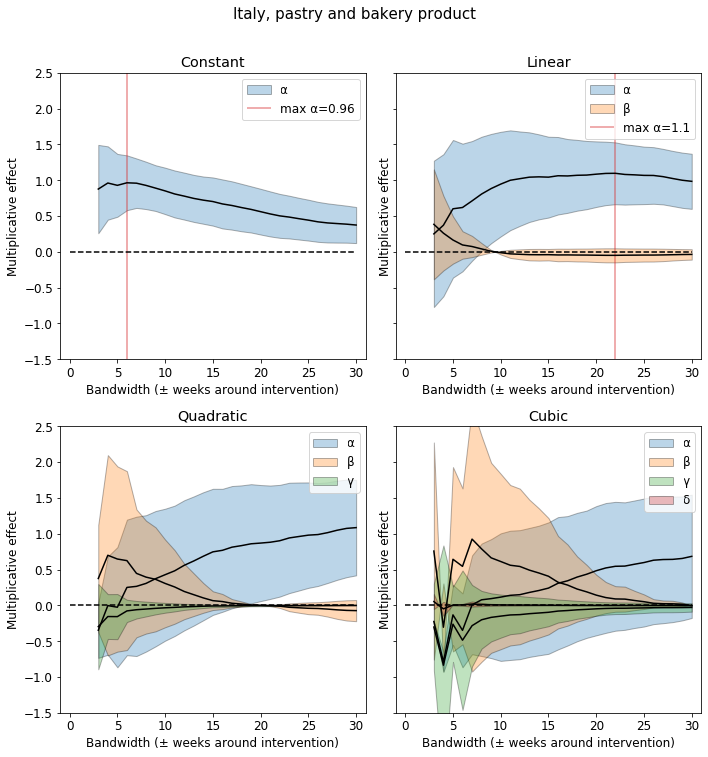

In [9]:
import matplotlib.pyplot as mpl
mpl.rcParams['font.size'] = 12

fig, axes = plt.subplots(2,2, figsize = (10,10), sharey = True)


for model in ['Constant','Linear','Quadratic','Cubic']:
    
    point = []
    conf = []
        
    for k in range(3,31):
    
        df_temp = df.loc[(df['category'] == 'pastry and bakery product') & 
                                    (df['country'] == 'IT') & \
                                    (df['k'] >= -k) & (df['k'] <= k)].copy()
        
        df_temp['volume_total'] = df_temp['volume_total'].apply(np.log)

        mod = smf.ols(generate_equation(model), 
                      data = df_temp)

        res = mod.fit(cov_type='hc0')
        
    
        if model == 'Cubic':
            point.append([res.params['intervention_flag:year[T.2020]'], res.params['intervention_flag:k:year[T.2020]'], res.params['intervention_flag:np.power(k, 2):year[T.2020]'], res.params['intervention_flag:np.power(k, 3):year[T.2020]']])
            conf.append([res.bse['intervention_flag:year[T.2020]'], res.params['intervention_flag:k:year[T.2020]'], res.params['intervention_flag:np.power(k, 2):year[T.2020]'], res.params['intervention_flag:np.power(k, 3):year[T.2020]']])
        elif model == "Quadratic":
            point.append([res.params['intervention_flag:year[T.2020]'], res.params['intervention_flag:k:year[T.2020]'], res.params['intervention_flag:np.power(k, 2):year[T.2020]']])
            conf.append([res.bse['intervention_flag:year[T.2020]'], res.params['intervention_flag:k:year[T.2020]'], res.params['intervention_flag:np.power(k, 2):year[T.2020]']])
        elif model == "Linear":
            point.append([res.params['intervention_flag:year[T.2020]'], res.params['intervention_flag:k:year[T.2020]']])
            conf.append([res.bse['intervention_flag:year[T.2020]'], res.params['intervention_flag:k:year[T.2020]']])
        elif model == 'Constant':
            point.append([res.params['intervention_flag:year[T.2020]']])
            conf.append([res.bse['intervention_flag:year[T.2020]']])
            
    if model == 'Constant':
        sbplt = axes[0,0]
        sbplt.plot(range(3,31), [i[0] for i in point], color = 'black')
        sbplt.fill_between(range(3,31),
                           np.array([i[0] for i in point]) - 2*np.array([i[0] for i in conf]), 
                           np.array([i[0] for i in point]) + 2*np.array([i[0] for i in conf]), alpha = 0.3, edgecolor = 'black', label = 'α')
        idmax = np.argmax(np.array([i[0] for i in point]))
        sbplt.vlines(range(3,31)[idmax],-1.5,2.5, alpha = 0.5, color = 'tab:red', label = 'max α='+str(round(np.max(np.array([i[0] for i in point])),2)))
        
    elif model == 'Linear':
        sbplt = axes[0,1]
        sbplt.plot(range(3,31), [i[0] for i in point], color = 'black')
        sbplt.fill_between(range(3,31), 
                           np.array([i[0] for i in point]) - 2*np.array([i[0] for i in conf]),
                           np.array([i[0] for i in point]) + 2*np.array([i[0] for i in conf]), alpha = 0.3, edgecolor = 'black', label = 'α')
        
        sbplt.plot(range(3,31), [i[1] for i in point], color = 'black')
        sbplt.fill_between(range(3,31), 
                           np.array([i[1] for i in point]) - 2*np.array([i[1] for i in conf]),
                           np.array([i[1] for i in point]) + 2*np.array([i[1] for i in conf]), alpha = 0.3, edgecolor = 'black', label = 'β')
        idmax = np.argmax(np.array([i[0] for i in point]))
        sbplt.vlines(range(3,31)[idmax],-1.5,2.5, alpha = 0.5, color = 'tab:red', label = 'max α='+str(round(np.max(np.array([i[0] for i in point])),2)))
        
    elif model == 'Quadratic':
        sbplt = axes[1,0]
        sbplt.plot(range(3,31), [i[0] for i in point], color = 'black')
        sbplt.fill_between(range(3,31),
                           np.array([i[0] for i in point]) - 2*np.array([i[0] for i in conf]), 
                           np.array([i[0] for i in point]) + 2*np.array([i[0] for i in conf]), alpha = 0.3, edgecolor = 'black', label = 'α')
        
        sbplt.plot(range(3,31), [i[1] for i in point], color = 'black')
        sbplt.fill_between(range(3,31), 
                           np.array([i[1] for i in point]) - 2*np.array([i[1] for i in conf]),
                           np.array([i[1] for i in point]) + 2*np.array([i[1] for i in conf]), alpha = 0.3, edgecolor = 'black', label = 'β')
    
        sbplt.plot(range(3,31), [i[2] for i in point], color = 'black')
        sbplt.fill_between(range(3,31), 
                           np.array([i[2] for i in point]) - 2*np.array([i[2] for i in conf]),
                           np.array([i[2] for i in point]) + 2*np.array([i[2] for i in conf]), alpha = 0.3, edgecolor = 'black', label = 'γ')
    
    else:
        sbplt = axes[1,1]
        sbplt.plot(range(3,31), [i[0] for i in point], color = 'black')
        sbplt.fill_between(range(3,31),
                           np.array([i[0] for i in point]) - 2*np.array([i[0] for i in conf]), 
                           np.array([i[0] for i in point]) + 2*np.array([i[0] for i in conf]), alpha = 0.3, edgecolor = 'black', label = 'α')
       
        sbplt.plot(range(3,31), [i[1] for i in point], color = 'black')
        sbplt.fill_between(range(3,31), 
                           np.array([i[1] for i in point]) - 2*np.array([i[1] for i in conf]),
                           np.array([i[1] for i in point]) + 2*np.array([i[1] for i in conf]), alpha = 0.3, edgecolor = 'black', label = 'β')
        
        sbplt.plot(range(3,31), [i[2] for i in point], color = 'black')
        sbplt.fill_between(range(3,31), 
                           np.array([i[2] for i in point]) - 2*np.array([i[2] for i in conf]),
                           np.array([i[2] for i in point]) + 2*np.array([i[2] for i in conf]), alpha = 0.3, edgecolor = 'black', label = 'γ')
        
        sbplt.plot(range(3,31), [i[3] for i in point], color = 'black')
        sbplt.fill_between(range(3,31), 
                           np.array([i[3] for i in point]) - 2*np.array([i[3] for i in conf]),
                           np.array([i[3] for i in point]) + 2*np.array([i[3] for i in conf]), alpha = 0.3, edgecolor = 'black', label = 'δ')
    
    
    sbplt.set_title(model)
    sbplt.legend(loc = "upper right")
    sbplt.hlines(0,0,30, linestyle = '--')
    sbplt.set_xticks(range(0,31)[::5])
    sbplt.set_xticklabels(range(0,31)[::5])
    sbplt.set_xlim([-1,31])
    sbplt.set_xlabel('Bandwidth (± weeks around intervention)')
    sbplt.set_ylabel('Multiplicative effect')
    sbplt.set_ylim([-1.5,2.5])

plt.tight_layout()

fig.suptitle('Italy, pastry and bakery product', position = (0.5,1.05), fontsize= 15)


plt.savefig(FIGURES_DIR+"example_italy_bread_vary_bandwidth.pdf", bbox_inches='tight')

In [10]:
cats = list(df['category'].unique())
k = 30

In [11]:
df_temp = df.loc[(df['k'] >= -k) & (df['k'] <= k)].copy()
df_temp['volume_total'] = df_temp['volume_total'].apply(np.log)
mod = smf.ols(generate_equation_interactions('Quadratic'), data = df_temp)
result_interactions = mod.fit(cov_type='hc0')

In [12]:
default_country = 'AU'
default_category = 'beef dish'

alpha_baseline = 'intervention_flag:year[T.2020]'
beta_baseline = 'intervention_flag:k:year[T.2020]'
gamma_baseline = 'intervention_flag:np.power(k, 2):year[T.2020]'

list_results = []

for country in full_names.keys():
    for c in cats:
        
        entry = {}
        entry['country']  = country
        entry['category'] = c
        
        suffix_country = (':C(country)[T.'+country+']')
        suffix_category = (':C(category)[T.'+c+']')
        
        if country == default_country and c == default_category:
            
            total_alpha = (result_interactions.params[alpha_baseline])
            total_alpha_error = (result_interactions.bse[alpha_baseline])
            
            total_beta = (result_interactions.params[beta_baseline])
            total_beta_error = (result_interactions.bse[beta_baseline])
            
            total_gamma = (result_interactions.params[gamma_baseline])
            total_gamma_error = (result_interactions.bse[gamma_baseline])
            
        elif country == default_country and c != default_category:
            
            total_alpha = (result_interactions.params[alpha_baseline]) \
                    + (result_interactions.params[alpha_baseline + suffix_category]) 
            total_alpha_error = (get_standard_error_sum([alpha_baseline, 
                                                         alpha_baseline + suffix_category]))
            
            total_beta = (result_interactions.params[beta_baseline]) \
                    + (result_interactions.params[beta_baseline + suffix_category]) 
            total_beta_error = (get_standard_error_sum([beta_baseline, 
                                                         beta_baseline + suffix_category]))
            
            total_gamma = (result_interactions.params[gamma_baseline]) \
                    + (result_interactions.params[gamma_baseline + suffix_category]) 
            total_gamma_error = (get_standard_error_sum([gamma_baseline, 
                                                         gamma_baseline + suffix_category]))

        elif country != default_country and c == default_category:
            
            total_alpha = (result_interactions.params[alpha_baseline]) \
                    + (result_interactions.params[alpha_baseline + suffix_country]) 
            total_alpha_error = (get_standard_error_sum([alpha_baseline,
                                                         alpha_baseline + suffix_country]))
            
            total_beta = (result_interactions.params[beta_baseline]) \
                    + (result_interactions.params[beta_baseline + suffix_country]) 
            total_beta_error = (get_standard_error_sum([beta_baseline,
                                                         beta_baseline + suffix_country]))
            
            total_gamma = (result_interactions.params[gamma_baseline]) \
                    + (result_interactions.params[gamma_baseline + suffix_country]) 
            total_gamma_error = (get_standard_error_sum([gamma_baseline,
                                                         gamma_baseline + suffix_country]))

        else:
            total_alpha = (result_interactions.params[alpha_baseline]) \
                    + (result_interactions.params[alpha_baseline + suffix_country]) \
                    + (result_interactions.params[alpha_baseline + suffix_category]) \
                    + (result_interactions.params[alpha_baseline + suffix_country + suffix_category])
            
            total_alpha_error = (get_standard_error_sum([alpha_baseline, 
                                                         alpha_baseline + suffix_category,
                                                         alpha_baseline + suffix_country, 
                                                         alpha_baseline + suffix_country + suffix_category]))
            
            total_beta = (result_interactions.params[beta_baseline]) \
                    + (result_interactions.params[beta_baseline + suffix_country]) \
                    + (result_interactions.params[beta_baseline + suffix_category]) \
                    + (result_interactions.params[beta_baseline + suffix_country + suffix_category])
            
            total_beta_error = (get_standard_error_sum([beta_baseline, 
                                                         beta_baseline + suffix_category,
                                                         beta_baseline + suffix_country, 
                                                         beta_baseline + suffix_country + suffix_category]))
            
            total_gamma = (result_interactions.params[gamma_baseline]) \
                    + (result_interactions.params[gamma_baseline + suffix_country]) \
                    + (result_interactions.params[gamma_baseline + suffix_category]) \
                    + (result_interactions.params[gamma_baseline + suffix_country + suffix_category])
            
            total_gamma_error = (get_standard_error_sum([gamma_baseline, 
                                                         gamma_baseline + suffix_category,
                                                         gamma_baseline + suffix_country, 
                                                         gamma_baseline + suffix_country + suffix_category]))
            
        entry['alpha'] = total_alpha
        entry['alpha_ste'] = total_alpha_error
        entry['beta'] = total_beta
        entry['beta_ste'] = total_beta_error
        entry['gamma'] = total_gamma
        entry['gamma_ste'] = total_gamma_error
        
        list_results.append(entry)
        
df_results = pd.DataFrame(list_results)
df_results_interactions = pd.DataFrame(list_results)

## a) For all categories, show alpha in different countries

In [13]:
cats_sorted = list(df_results.groupby('category')['alpha'].agg('mean').sort_values(ascending = False).index)
countries_sorted = list(df_results.groupby('country')['alpha'].\
     agg('mean').sort_values(ascending = False).index)

In [14]:
sorterIndex = dict(zip(countries_sorted, range(len(countries_sorted))))

def sort_pd(key=None,reverse=False):
    def sorter(series):
        series_list = list(series)
        return [series_list.index(i) 
           for i in sorted(series_list,key=key,reverse=reverse)]
    return sorter

sort_by_custom_dict = sort_pd(key=sorterIndex.get)

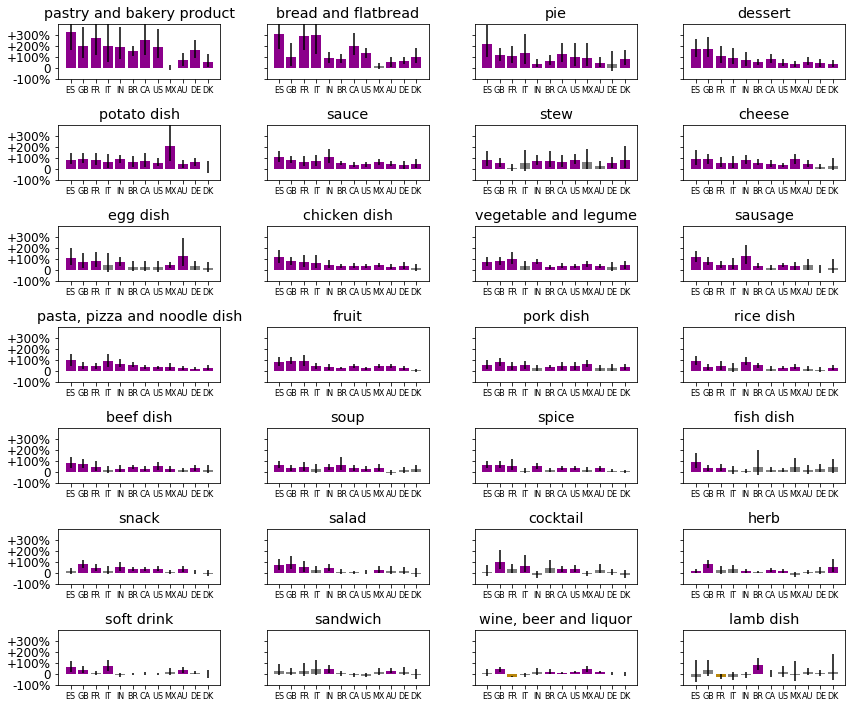

In [15]:
fig, axes = plt.subplots(7,4, figsize = (12,10), sharey = True)

for cnt,c in enumerate(cats_sorted):
    sbplt = axes[math.floor(cnt/4), cnt%4]
    x = df_results.loc[df_results['category'] == c].iloc[sort_by_custom_dict(df_results.loc[df_results['category'] == c]['country'])][['alpha','country','alpha_ste']]
    
    colors_bars = []
    for i in range(12):
        if x['alpha'].values[i]>0 and x['alpha'].values[i]-2*x['alpha_ste'].values[i]>0:
            colors_bars.append('darkmagenta')
        elif x['alpha'].values[i]<0 and x['alpha'].values[i]+2*x['alpha_ste'].values[i]<0:
            colors_bars.append('darkgoldenrod')
        else:
            colors_bars.append('gray')
            
    #sbplt.bar(range(12),x['alpha'].apply(lambda x: np.exp(x)-1), yerr = 2*x['alpha_ste'].apply(lambda x: np.exp(x)-1), color = colors_bars)
    
    sbplt.bar(range(12),x['alpha'].apply(lambda x: np.exp(x)-1),
            #here we convert errors back to linear scale
            yerr = np.array([x['alpha'].apply(lambda x: np.exp(x)-1) - (x['alpha']-2*x['alpha_ste']).apply(lambda x: np.exp(x)-1),
                            (x['alpha']+2*x['alpha_ste']).apply(lambda x: np.exp(x)-1) - x['alpha'].apply(lambda x: np.exp(x)-1)]), 
            color = colors_bars)
    
    sbplt.set_xticks(range(12))
    sbplt.set_xticklabels(x['country'], fontsize= 8)
    sbplt.set_title(c)
    
    sbplt.set_yticks([-1,0,1,2,3])
    sbplt.set_yticklabels(["-100%","0","+100%","+200%","+300%"])
    sbplt.set_ylim([-1,4])

#fig.suptitle("α", position = (0.5, 1.05))
plt.tight_layout()

plt.savefig(FIGURES_DIR+"cats_effects.pdf", bbox_inches='tight')

## b) In all countries, show alpha in different categories

In [16]:
sorterIndex = dict(zip(cats_sorted, range(len(cats_sorted))))

def sort_pd(key=None,reverse=False):
    def sorter(series):
        series_list = list(series)
        return [series_list.index(i) 
           for i in sorted(series_list,key=key,reverse=reverse)]
    return sorter

sort_by_custom_dict = sort_pd(key=sorterIndex.get)

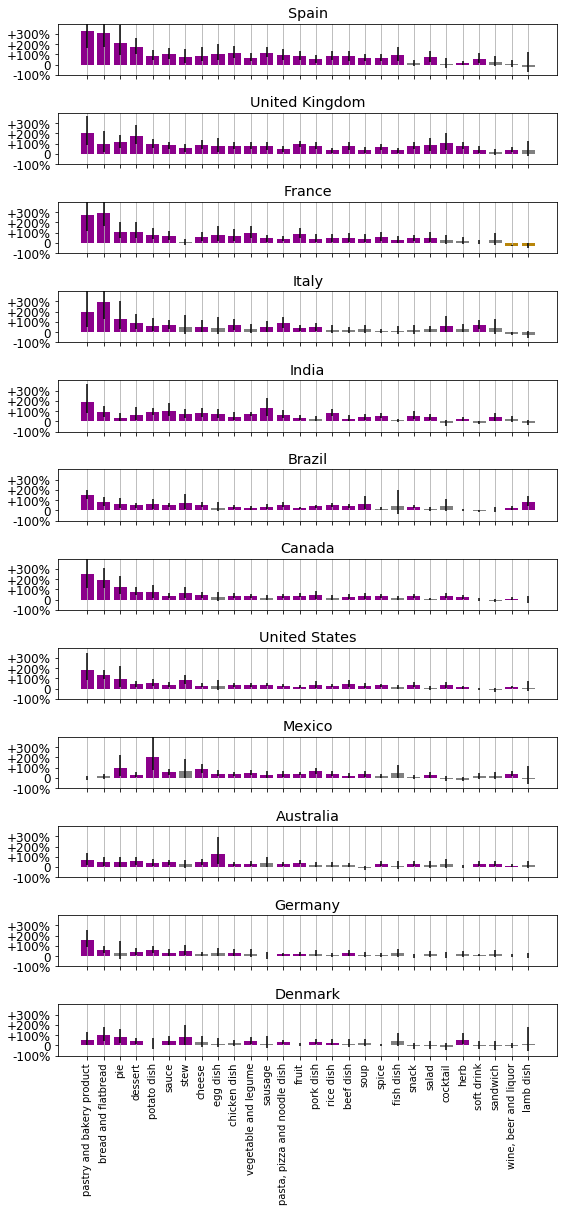

In [17]:
fig, axes = plt.subplots(12,1, figsize = (8,17), sharey = True)

for cnt,country in enumerate(countries_sorted):    
    sbplt = axes[cnt]
    
    x = df_results.loc[df_results['country'] == country].iloc[sort_by_custom_dict(df_results.loc[df_results['country'] == country]['category'])][['alpha','category','alpha_ste']]
    #x = df_results.loc[df_results['country'] == country].sort_values(by='category', ascending = True)[['alpha','category','alpha_ste']]
    
    colors_bars = []
    for i in range(28):
        if x['alpha'].values[i]>0 and x['alpha'].values[i]-2*x['alpha_ste'].values[i]>0:
            colors_bars.append('darkmagenta')
        elif x['alpha'].values[i]<0 and x['alpha'].values[i]+2*x['alpha_ste'].values[i]<0:
            colors_bars.append('darkgoldenrod')
        else:
            colors_bars.append('gray')
            
            
    sbplt.bar(range(28),x['alpha'].apply(lambda x: np.exp(x)-1),
            #here we convert errors back to linear scale
            yerr = np.array([x['alpha'].apply(lambda x: np.exp(x)-1) - (x['alpha']-2*x['alpha_ste']).apply(lambda x: np.exp(x)-1),
                            (x['alpha']+2*x['alpha_ste']).apply(lambda x: np.exp(x)-1) - x['alpha'].apply(lambda x: np.exp(x)-1)]), 
            color = colors_bars
           )
    
    sbplt.set_ylim([-1,4])

    sbplt.set_xticks(range(28))
    
    if cnt == 11:
        sbplt.set_xticklabels(x['category'], fontsize= 10, rotation = 90)
    else:
        sbplt.set_xticklabels([])

    sbplt.set_title(full_names[country])

    sbplt.set_yticks([-1,0,1,2,3])
    sbplt.set_yticklabels(["-100%","0","+100%","+200%","+300%"])
    sbplt.set_ylim([-1,4])
    
    sbplt.grid(axis = 'x')


#fig.suptitle("α", position = (0.5, 1))
plt.tight_layout()

plt.savefig(FIGURES_DIR+"cats_effects_by_country.pdf", bbox_inches='tight')

## Calculate overall increase in all foods in a country

In [18]:
country_totals = []

for c,gr in df_agg.groupby('country'):
    entry = {}
    entry['country'] = c
    entry['total'] = gr['volume_weekly_total'].sum()
    country_totals.append(entry)

In [19]:
country_totals = pd.DataFrame((country_totals))

In [20]:
country_totals = country_totals.loc[(country_totals['country'].isin(list(full_names.keys())))]

In [21]:
country_totals['average total'] = [i.mean() for i in country_totals['total'].values]

In [22]:
#country_totals = country_totals.sort_values(by = 'average total', ascending = False)

In [23]:
country_totals = country_totals.sort_values(by = 'country', ascending = True)

In [53]:
row['total'].index[:52]

Index(['2019-01-06', '2019-01-13', '2019-01-20', '2019-01-27', '2019-02-03',
       '2019-02-10', '2019-02-17', '2019-02-24', '2019-03-03', '2019-03-10',
       '2019-03-17', '2019-03-24', '2019-03-31', '2019-04-07', '2019-04-14',
       '2019-04-21', '2019-04-28', '2019-05-05', '2019-05-12', '2019-05-19',
       '2019-05-26', '2019-06-02', '2019-06-09', '2019-06-16', '2019-06-23',
       '2019-06-30', '2019-07-07', '2019-07-14', '2019-07-21', '2019-07-28',
       '2019-08-04', '2019-08-11', '2019-08-18', '2019-08-25', '2019-09-01',
       '2019-09-08', '2019-09-15', '2019-09-22', '2019-09-29', '2019-10-06',
       '2019-10-13', '2019-10-20', '2019-10-27', '2019-11-03', '2019-11-10',
       '2019-11-17', '2019-11-24', '2019-12-01', '2019-12-08', '2019-12-15',
       '2019-12-22', '2019-12-29'],
      dtype='object')

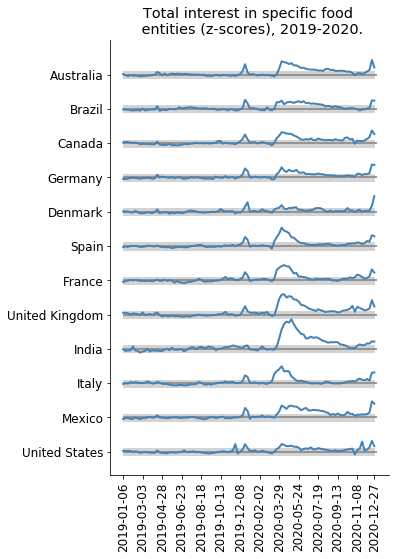

In [65]:
fig, ax = plt.subplots(1,1,figsize= (5,8))
c= 0


constant_shift = -19
for cnt,row in country_totals.iterrows():
    mean_2019 = row['total'].values[:52].mean()
    std_2019 = row['total'].values[:52].std()
    plt.plot(row['total'].index,constant_shift*c+((row['total'].values - mean_2019) / std_2019) ,
             linewidth = 2,label = full_names[row['country']], color = 'steelblue')

    plt.hlines(constant_shift*c,0,104, color = 'gray')
    
    #plt.hlines(-5*c+2,0,104, color = 'gray', linestyle = '--', alpha = 0.5)
    
    #plt.hlines(-5*c-2,0,104, color = 'gray', linestyle = '--', alpha = 0.5)
    
    
    plt.fill_between(row['total'].index, constant_shift*c-2, constant_shift*c+2, color = 'lightgray')
    c+=1
#plt.legend(loc = "upper right", fontsize= 10)
#plt.yscale('log')

plt.xticks(np.concatenate((row['total'].index[::8],[row['total'].index[-1]])), rotation=90);
#plt.xlim([-10,150])

plt.title('Total interest in specific food \n entities (z-scores), 2019-2020.')




ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.yticks(np.array(range(12))*constant_shift, [full_names[row['country']] for cnt,row in country_totals.iterrows()])

plt.savefig(FIGURES_DIR+"total_entities.pdf", bbox_inches='tight')

In [25]:
list_total_effects = []

for cnt,row in country_totals.iterrows():
    
    l = []
    start_md = df_events.loc[df_events['country'] == row['country']].iloc[0]['start_md_1']
    end_md = df_events.loc[df_events['country'] == row['country']].iloc[0]['end_md_1']
    start_md2 = df_events.loc[df_events['country'] == row['country']].iloc[0]['start_md_2']

    for week in zip(row['total'].index,row['total'].values):

        entry = {}


        if week[0] in weeks_2020:
            date = pd.to_datetime(week[0])

            if type(start_md2)!=pd._libs.tslibs.nattype.NaTType and date > start_md2:
                continue

            entry['k'] = math.floor(((date - start_md).days +7) / 7)
            entry['volume_total'] = week[1]
            entry['year'] = '2020'
            l.append(entry)

        elif week[0] in weeks_2019:
            date = pd.to_datetime(weeks_2020[weeks_2019.index(week[0])])

            if type(start_md2)!=pd._libs.tslibs.nattype.NaTType and date > start_md2:
                continue

            entry['k'] = math.floor(((date - start_md).days +7) / 7)
            entry['volume_total'] = week[1]
            entry['year'] = '2019'
            l.append(entry)

    df_totals = pd.DataFrame(l)
    
    k = 30
    df_totals['intervention_flag'] = df_totals['k'].apply(lambda x: 1 if x >= 0 else 0)
    df_temp = df_totals.loc[(df_totals['k'] >= -k) & (df_totals['k'] <= k)].copy()
    df_temp['volume_total'] = df_temp['volume_total'].apply(np.log)
    
    mod = smf.ols(generate_equation('Quadratic'), data = df_temp)
    result = mod.fit(cov_type='hc0')

    alpha = 'intervention_flag:year[T.2020]'

    entry = {}
    entry['alpha_param'] = result.params[alpha]
    entry['alpha_ste'] = result.bse[alpha]
    entry['country'] = row['country']
    list_total_effects.append(entry)


In [26]:
list_total_effects

[{'alpha_param': 0.30794676053740666,
  'alpha_ste': 0.0820844863173472,
  'country': 'AU'},
 {'alpha_param': 0.3369541684051125,
  'alpha_ste': 0.055161501901558004,
  'country': 'BR'},
 {'alpha_param': 0.35373717975464736,
  'alpha_ste': 0.08340778089671172,
  'country': 'CA'},
 {'alpha_param': 0.23750750383183838,
  'alpha_ste': 0.09049655208620756,
  'country': 'DE'},
 {'alpha_param': 0.22244612984308798,
  'alpha_ste': 0.05851833225366195,
  'country': 'DK'},
 {'alpha_param': 0.6934846336579827,
  'alpha_ste': 0.12215579374490713,
  'country': 'ES'},
 {'alpha_param': 0.5637338528357869,
  'alpha_ste': 0.13247973428433346,
  'country': 'FR'},
 {'alpha_param': 0.6162139726093145,
  'alpha_ste': 0.0975325843174601,
  'country': 'GB'},
 {'alpha_param': 0.42791266215443624,
  'alpha_ste': 0.10319037556614889,
  'country': 'IN'},
 {'alpha_param': 0.4934554523702347,
  'alpha_ste': 0.14607797561788247,
  'country': 'IT'},
 {'alpha_param': 0.30562550480358164,
  'alpha_ste': 0.06399183956

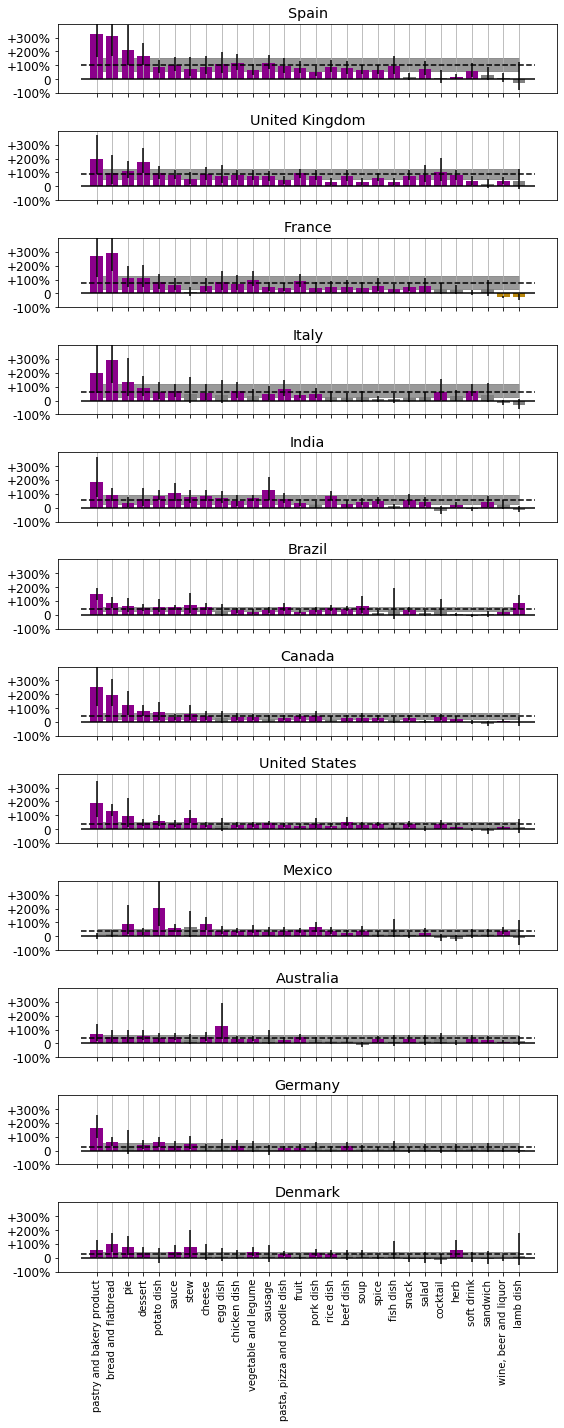

In [27]:
fig, axes = plt.subplots(12,1, figsize = (8,20), sharey = True)

for cnt,country in enumerate(countries_sorted):    
    sbplt = axes[cnt]
    
    x = df_results.loc[df_results['country'] == country].iloc[sort_by_custom_dict(df_results.loc[df_results['country'] == country]['category'])][['alpha','category','alpha_ste']]
    #x = df_results.loc[df_results['country'] == country].sort_values(by='category', ascending = True)[['alpha','category','alpha_ste']]
    
    colors_bars = []
    for i in range(28):
        if x['alpha'].values[i]>0 and x['alpha'].values[i]-2*x['alpha_ste'].values[i]>0:
            colors_bars.append('darkmagenta')
        elif x['alpha'].values[i]<0 and x['alpha'].values[i]+2*x['alpha_ste'].values[i]<0:
            colors_bars.append('darkgoldenrod')
        else:
            colors_bars.append('gray')
            
            
    sbplt.bar(range(28),x['alpha'].apply(lambda x: np.exp(x)-1),
            #here we convert errors back to linear scale
            yerr = np.array([x['alpha'].apply(lambda x: np.exp(x)-1) - (x['alpha']-2*x['alpha_ste']).apply(lambda x: np.exp(x)-1),
                            (x['alpha']+2*x['alpha_ste']).apply(lambda x: np.exp(x)-1) - x['alpha'].apply(lambda x: np.exp(x)-1)]), 
            color = colors_bars
           )
    
    sbplt.set_ylim([-2,4])

    sbplt.set_xticks(range(28))
    
    if cnt == 11:
        sbplt.set_xticklabels(x['category'], fontsize= 10, rotation = 90)
    else:
        sbplt.set_xticklabels([])

    sbplt.set_title(full_names[country])

    sbplt.set_yticks([-1,0,1,2,3])
    sbplt.set_yticklabels(["-100%","0","+100%","+200%","+300%"])
    sbplt.set_ylim([-1,4])
    
    sbplt.grid(axis = 'x')
    
    coef_total = [i for i in list_total_effects if i['country']==country][0]['alpha_param']
    bse = [i for i in list_total_effects if i['country']==country][0]['alpha_ste']
    
    sbplt.hlines(np.exp(coef_total) - 1, -1,28, linestyle = '--')
    sbplt.fill_between(range(28), np.exp(coef_total-2*bse) - 1, np.exp(coef_total+2*bse) - 1, 
                       color = 'grey', alpha = 0.8)

    sbplt.hlines(0, -1,28)
#fig.suptitle("α", position = (0.5, 1))
plt.tight_layout()

plt.savefig(FIGURES_DIR+"cats_effects_by_country.pdf", bbox_inches='tight')

## c) 2D visualization in category effect space

In [28]:
array_pca = []

for cnt,country in enumerate(countries_sorted):    
    x = df_results.loc[df_results['country'] == country].sort_values(by='category', ascending = True)[['alpha','category','alpha_ste']]
    array_pca.append(x['alpha'].values)

transformed = StandardScaler().fit_transform(np.array(array_pca))

In [29]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2)
#pca = PCA(n_components=5)
transformed = embedding.fit_transform(transformed)

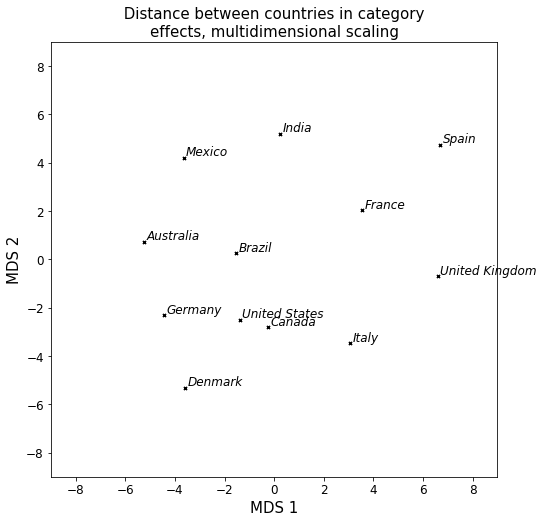

In [30]:
fig, axes = plt.subplots(1,1,figsize= (8,8))

for cnt,i in enumerate(transformed):
    plt.scatter(i[0],i[1], marker = 'x', s= 10, color = 'black')
    
    
    if countries_sorted[cnt] == 'US':
        plt.annotate(full_names[countries_sorted[cnt]],#+'\n'+\
                 #dict_max_mobility[countries_sorted[cnt]][0],
                (i[0]+0.1,i[1]+0.1), 
                 style = 'italic', fontsize = 12)
    else:
        plt.annotate(full_names[countries_sorted[cnt]], #+'\n'+\
                 #dict_max_mobility[countries_sorted[cnt]][0],
                     (i[0]+0.1,i[1]+0.1), 
                 style = 'italic', fontsize = 12)
        
    #plt.scatter(i[0],i[1],s = (dict_max_mobility[countries_sorted[cnt]][1]*3)**2, color = 'tab:blue', alpha = 0.2)
    
plt.ylim([-9,9])
plt.xlim([-9,9])
plt.xlabel('MDS 1', fontsize= 15)
           #+ str(100*embedding.explained_variance_ratio_[0])[:4]+"%)")
plt.ylabel('MDS 2', fontsize= 15)
           #str(100*embedding.explained_variance_ratio_[1])[:4]+"%)")
    
plt.title(' Distance between countries in category \neffects, multidimensional scaling', fontsize= 15);

plt.savefig(FIGURES_DIR+"categories_mds.pdf", bbox_inches='tight')

In [31]:
array_pca = []

for cnt,country in enumerate(countries_sorted):    
    x = df_results.loc[df_results['country'] == country].sort_values(by='category', ascending = True)[['alpha','category','alpha_ste']]
    array_pca.append(x['alpha'].values)
d = pd.DataFrame(np.array(array_pca))
d = d.set_index(pd.Index(countries_sorted))

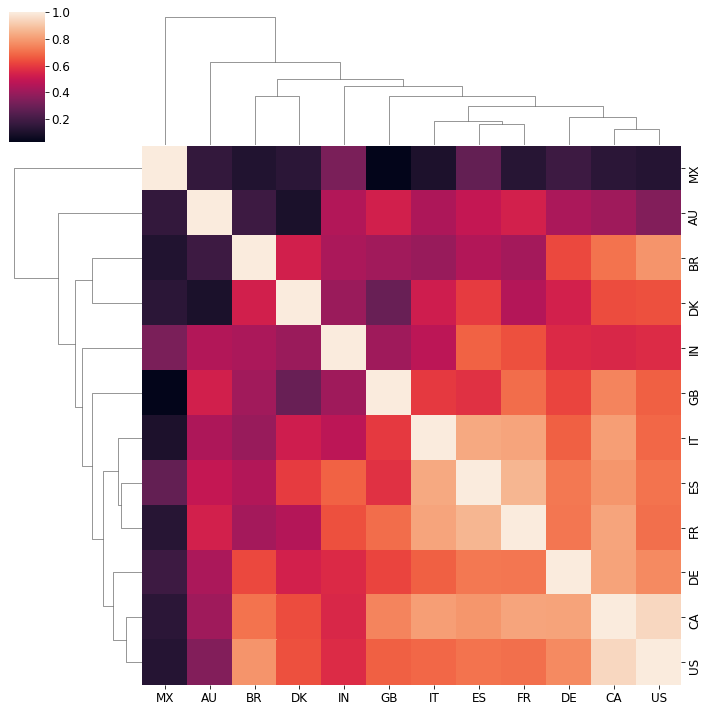

In [32]:
g = sns.clustermap(d.T.corr())

plt.savefig(FIGURES_DIR+"clustermap.pdf", bbox_inches='tight')

## d) Get number of days until back to normal, for each country and for each category

In [33]:
df_temp = df.loc[(df['k'] >= -k) & (df['k'] <= k)].copy()
df_temp['volume_total'] = df_temp['volume_total'].apply(np.log)
mod = smf.ols(generate_equation_interactions('Quadratic'), data = df_temp)
result_interactions = mod.fit(cov_type='hc0')

In [34]:
default_country = 'AU'
default_category = 'beef dish'

alpha_baseline = 'intervention_flag:year[T.2020]'
beta_baseline = 'intervention_flag:k:year[T.2020]'
gamma_baseline = 'intervention_flag:np.power(k, 2):year[T.2020]'

list_results = []

for country in full_names.keys():
    for c in cats:
        
        entry = {}
        entry['country']  = country
        entry['category'] = c
        
        suffix_country = (':C(country)[T.'+country+']')
        suffix_category = (':C(category)[T.'+c+']')
        
        if country == default_country and c == default_category:
            
            total_alpha = (result_interactions.params[alpha_baseline])
            total_alpha_error = (result_interactions.bse[alpha_baseline])
            
            total_beta = (result_interactions.params[beta_baseline])
            total_beta_error = (result_interactions.bse[beta_baseline])
            
            total_gamma = (result_interactions.params[gamma_baseline])
            total_gamma_error = (result_interactions.bse[gamma_baseline])
            
        elif country == default_country and c != default_category:
            
            total_alpha = (result_interactions.params[alpha_baseline]) \
                    + (result_interactions.params[alpha_baseline + suffix_category]) 
            total_alpha_error = (get_standard_error_sum([alpha_baseline, 
                                                         alpha_baseline + suffix_category]))
            
            total_beta = (result_interactions.params[beta_baseline]) \
                    + (result_interactions.params[beta_baseline + suffix_category]) 
            total_beta_error = (get_standard_error_sum([beta_baseline, 
                                                         beta_baseline + suffix_category]))
            
            total_gamma = (result_interactions.params[gamma_baseline]) \
                    + (result_interactions.params[gamma_baseline + suffix_category]) 
            total_gamma_error = (get_standard_error_sum([gamma_baseline, 
                                                         gamma_baseline + suffix_category]))

        elif country != default_country and c == default_category:
            
            total_alpha = (result_interactions.params[alpha_baseline]) \
                    + (result_interactions.params[alpha_baseline + suffix_country]) 
            total_alpha_error = (get_standard_error_sum([alpha_baseline,
                                                         alpha_baseline + suffix_country]))
            
            total_beta = (result_interactions.params[beta_baseline]) \
                    + (result_interactions.params[beta_baseline + suffix_country]) 
            total_beta_error = (get_standard_error_sum([beta_baseline,
                                                         beta_baseline + suffix_country]))
            
            total_gamma = (result_interactions.params[gamma_baseline]) \
                    + (result_interactions.params[gamma_baseline + suffix_country]) 
            total_gamma_error = (get_standard_error_sum([gamma_baseline,
                                                         gamma_baseline + suffix_country]))

        else:
            total_alpha = (result_interactions.params[alpha_baseline]) \
                    + (result_interactions.params[alpha_baseline + suffix_country]) \
                    + (result_interactions.params[alpha_baseline + suffix_category]) \
                    + (result_interactions.params[alpha_baseline + suffix_country + suffix_category])
            
            total_alpha_error = (get_standard_error_sum([alpha_baseline, 
                                                         alpha_baseline + suffix_category,
                                                         alpha_baseline + suffix_country, 
                                                         alpha_baseline + suffix_country + suffix_category]))
            
            total_beta = (result_interactions.params[beta_baseline]) \
                    + (result_interactions.params[beta_baseline + suffix_country]) \
                    + (result_interactions.params[beta_baseline + suffix_category]) \
                    + (result_interactions.params[beta_baseline + suffix_country + suffix_category])
            
            total_beta_error = (get_standard_error_sum([beta_baseline, 
                                                         beta_baseline + suffix_category,
                                                         beta_baseline + suffix_country, 
                                                         beta_baseline + suffix_country + suffix_category]))
            
            total_gamma = (result_interactions.params[gamma_baseline]) \
                    + (result_interactions.params[gamma_baseline + suffix_country]) \
                    + (result_interactions.params[gamma_baseline + suffix_category]) \
                    + (result_interactions.params[gamma_baseline + suffix_country + suffix_category])
            
            total_gamma_error = (get_standard_error_sum([gamma_baseline, 
                                                         gamma_baseline + suffix_category,
                                                         gamma_baseline + suffix_country, 
                                                         gamma_baseline + suffix_country + suffix_category]))
            
        entry['alpha'] = total_alpha
        entry['alpha_ste'] = total_alpha_error
        entry['beta'] = total_beta
        entry['beta_ste'] = total_beta_error
        entry['gamma'] = total_gamma
        entry['gamma_ste'] = total_gamma_error
        
        list_results.append(entry)
        
df_results = pd.DataFrame(list_results)

In [35]:
lst_heatmap = []
lst_heatmap_size_long_term = []

for c in cats:
    for country in sorted(list(full_names.keys())):
        #if c == 'bread and flatbread':
            entry = {}
            entry['country'] = country
            entry['category'] = c
            
            entry2 = {}
            entry2['country'] = country
            entry2['category'] = c
            #print(country, c)
            
            x = df_results.loc[(df_results['country'] == country) & (df_results['category'] == c)].iloc[0].copy()
            
            if (x['alpha']>0 and x['alpha']-2*x['alpha_ste']>0) or (x['alpha']<0 and x['alpha']+2*x['alpha_ste']<0):
                #print('significant short term increase or decrease')
                tmp = df_temp.loc[(df_temp['country'] == country)&(df_temp['category'] == c)].copy()

                #2019
                tmp1 = tmp.loc[tmp['year'] == '2019'].copy()

                tmp2 = tmp.loc[tmp['year'] == '2020'].copy()

                upper_error_2019 = result_interactions.get_prediction(tmp1.loc[tmp1['k']>=0]).conf_int()[:,1]
                lower_error_2020 = result_interactions.get_prediction(tmp2.loc[tmp2['k']>=0]).conf_int()[:,0]
                
                lower_error_2019 = result_interactions.get_prediction(tmp1.loc[tmp1['k']>=0]).conf_int()[:,0]
                upper_error_2020 = result_interactions.get_prediction(tmp2.loc[tmp2['k']>=0]).conf_int()[:,1]
                
                if ((x['alpha']>0 and x['alpha']-2*x['alpha_ste']>0) and sum(lower_error_2020 < upper_error_2019) == 0) or \
                ((x['alpha']<0 and x['alpha']-2*x['alpha_ste']<0) and sum(upper_error_2020 > lower_error_2019) == 0):
                    #print(c,country,'doesn fall back')
                    #print('doesn\'t fall back to normal')
                    mean2 = (np.mean(result_interactions.get_prediction(tmp2.loc[tmp2['k']>=0]).predicted_mean[-4:]))
                    mean1 = (np.mean(result_interactions.get_prediction(tmp1.loc[tmp1['k']>=0]).predicted_mean[-4:]))
                    
                    entry2['value'] = (np.exp(mean2) - np.exp(mean1)) / np.exp(mean1)

                    entry['value'] = 1000
                else:
                    if (x['alpha']>0 and x['alpha']-2*x['alpha_ste']>0):
                        v = (lower_error_2020 < upper_error_2019).argmax() + 1
                        #print(c,country,'falls back in',v)
                        #print('falls back to normal in ',v)
                        entry['value'] = v
                        entry2['value'] = 0
                    elif (x['alpha']<0 and x['alpha']+2*x['alpha_ste']<0):
                        v = (upper_error_2020 > lower_error_2019).argmax() + 1
                        #print(c,country,'falls back in',v)
                        #print('falls back to normal in ',v)
                        entry['value'] = v
                        entry2['value'] = 0
            else:
                entry['value'] = 0
                entry2['value'] = 0
                #print(c,country,'nosign changes')
                #('no significant short term changes')
            
            lst_heatmap.append(entry)
            lst_heatmap_size_long_term.append(entry2)

    

In [36]:
df_heatmap = pd.DataFrame(lst_heatmap)
matrix = np.zeros((28,12))

df_heatmap_longterm = pd.DataFrame(lst_heatmap_size_long_term)
matrix_longterm = np.zeros((28,12))

In [37]:
for cnt1,country in enumerate(countries_sorted):   
    for cnt2,cat in enumerate(cats_sorted):
        x = df_heatmap.loc[(df_heatmap['country'] == country) & (df_heatmap['category'] == cat)].iloc[0].copy()
        matrix[cnt2,cnt1] = (x['value'])    

In [38]:
for cnt1,country in enumerate(countries_sorted):   
    for cnt2,cat in enumerate(cats_sorted):
        x = df_heatmap_longterm.loc[(df_heatmap_longterm['country'] == country) & (df_heatmap_longterm['category'] == cat)].iloc[0].copy()
        matrix_longterm[cnt2,cnt1] = (x['value'])    

In [39]:
mask = (matrix <2) + (matrix > 999)

In [40]:
annotations = np.empty((12,28), dtype='object')

for i in range(12):
    for j in range(28):
        if (matrix > 999)[j][i]:    
            annotations[i][j] = "+"
        else:
            annotations[i][j] = ""

In [41]:
annotations = np.empty((12,28), dtype='object')

for i in range(12):
    for j in range(28):
        if (matrix > 140)[j][i]:    
            if matrix_longterm[j][i]>0:
                annotations[i][j] = "+"+str(matrix_longterm[j][i]*100)[:4]+"%"
            else:
                annotations[i][j] = str(matrix_longterm[j][i]*100)[:4]+"%"
        else:
            annotations[i][j] = ""

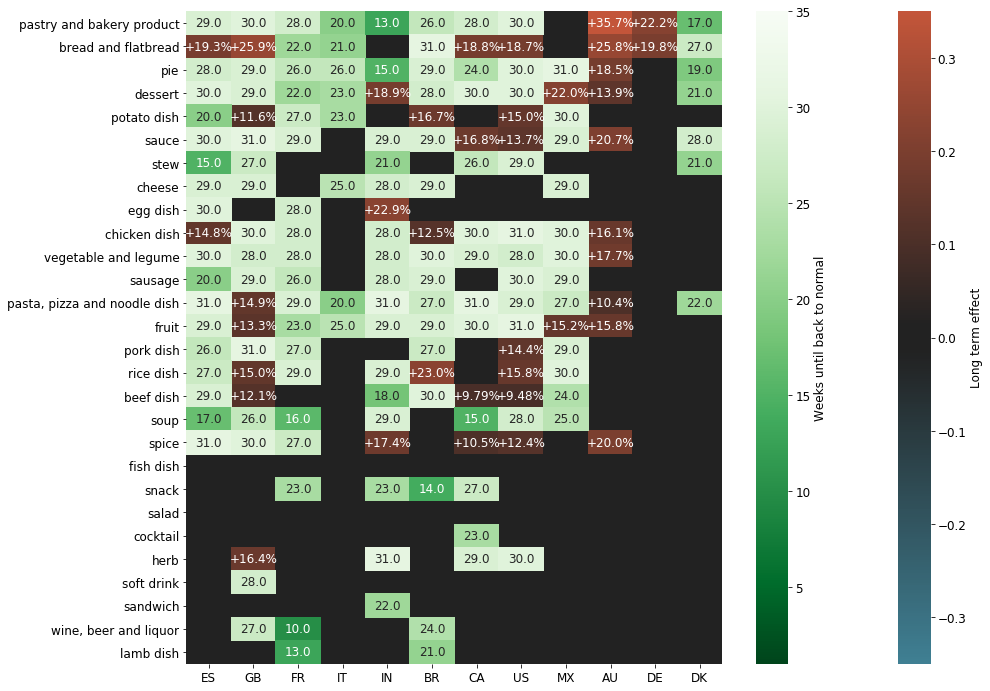

In [42]:
fig, ax = plt.subplots(1,1,figsize= (15,12))
matplotlib.rcParams.update({'font.size': 12})
sns.heatmap(matrix_longterm,  vmin = -0.35, vmax = 0.35, cbar_kws={'label': 'Long term effect'}, 
            cmap = sns.diverging_palette(220, 20, as_cmap=True, center = 'dark'),
            annot = annotations.T,  fmt="")

sns.heatmap(matrix, mask = mask, vmin = 1, vmax = 35, annot=True, fmt=".1f", 
            cmap="Greens_r", cbar_kws={'label': 'Weeks until back to normal'})

ax.set_yticks(np.array(range(28))+0.5)
ax.set_yticklabels(cats_sorted, rotation = 0);

ax.set_xticks(np.array(range(12))+0.5)
ax.set_xticklabels(countries_sorted, rotation = 0);

plt.savefig(FIGURES_DIR+"categories_longterm.pdf", bbox_inches='tight')

### Plot separately time to normal

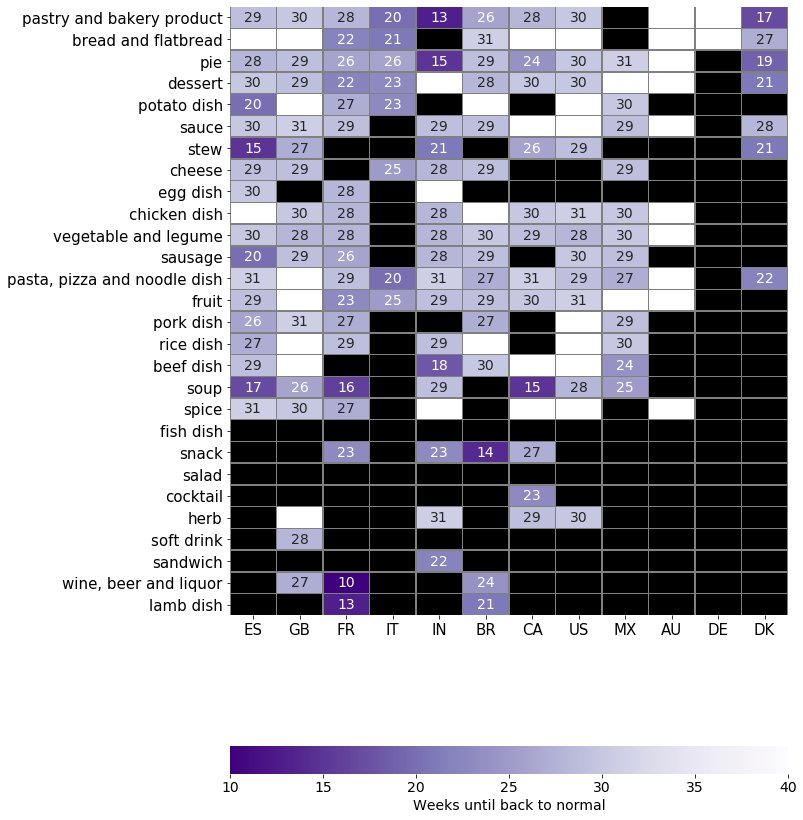

In [43]:
fig, ax = plt.subplots(1,1,figsize= (10,16))
matplotlib.rcParams.update({'font.size': 14})

sns.heatmap(matrix_longterm>0, cbar=False,  cmap = "Greys_r",  linewidths = 0.5,linecolor = 'gray',
            annot = False,  fmt="");

sns.heatmap(matrix, mask = mask, vmin = 10, vmax = 40, annot=True, fmt=".0f", 
            cmap="Purples_r", cbar_kws=dict(use_gridspec=False,label='Weeks until back to normal',location="bottom"), linewidths = 0.5,linecolor = 'gray')

ax.set_yticks(np.array(range(28))+0.5)
ax.set_yticklabels(cats_sorted, rotation = 0,fontsize = 15);

ax.set_xticks(np.array(range(12))+0.5)
ax.set_xticklabels(countries_sorted, rotation = 0, fontsize = 15);


plt.savefig(FIGURES_DIR+"categories_time.pdf", bbox_inches='tight')

### Plot separately longterm effect

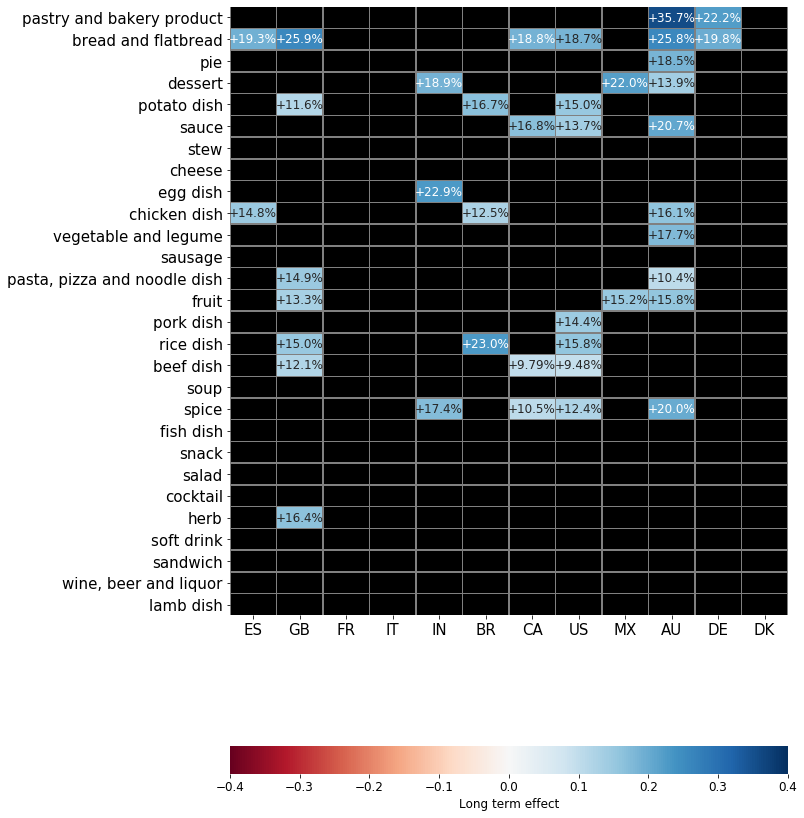

In [44]:
fig, ax = plt.subplots(1,1,figsize= (10,16))
matplotlib.rcParams.update({'font.size': 12})




sns.heatmap(matrix_longterm, vmin = -0.4, vmax = 0.4, cbar_kws=dict(use_gridspec=False,label='Long term effect',location="bottom"),  linewidths = 0.5,linecolor = 'gray',
            cmap = "RdBu",
            annot = annotations.T,  fmt="")

sns.heatmap(matrix_longterm, mask = matrix_longterm >0.01,vmin = 0, cbar=False, linewidths = 0.5,linecolor = 'gray',
            cmap = "Greys_r",
            annot = False,  fmt="")

ax.set_yticks(np.array(range(28))+0.5)
ax.set_yticklabels(cats_sorted, rotation = 0,fontsize = 15);

ax.set_xticks(np.array(range(12))+0.5)
ax.set_xticklabels(countries_sorted, rotation = 0, fontsize = 15);


plt.savefig(FIGURES_DIR+"categories_longterm.pdf", bbox_inches='tight')

## e) Make examples of the fit

Australia
 α=0.52* (+68.2%),
 β=-0.12*
Brazil
 α=0.91* (+148.2%),
 β=-0.0
Canada
 α=1.26* (+251.3%),
 β=-0.01
Germany
 α=0.96* (+161.4%),
 β=-0.09*
Denmark
 α=0.43* (+53.5%),
 β=0.01
Spain
 α=1.45* (+325.0%),
 β=-0.14*
France
 α=1.32* (+272.5%),
 β=-0.03
United Kingdom
 α=1.1* (+199.8%),
 β=-0.15*
India
 α=1.05* (+186.7%),
 β=0.01
Italy
 α=1.08* (+195.9%),
 β=-0.07
Mexico
 α=-0.0 (+-0.1%),
 β=0.05
United States
 α=1.06* (+187.3%),
 β=0.03


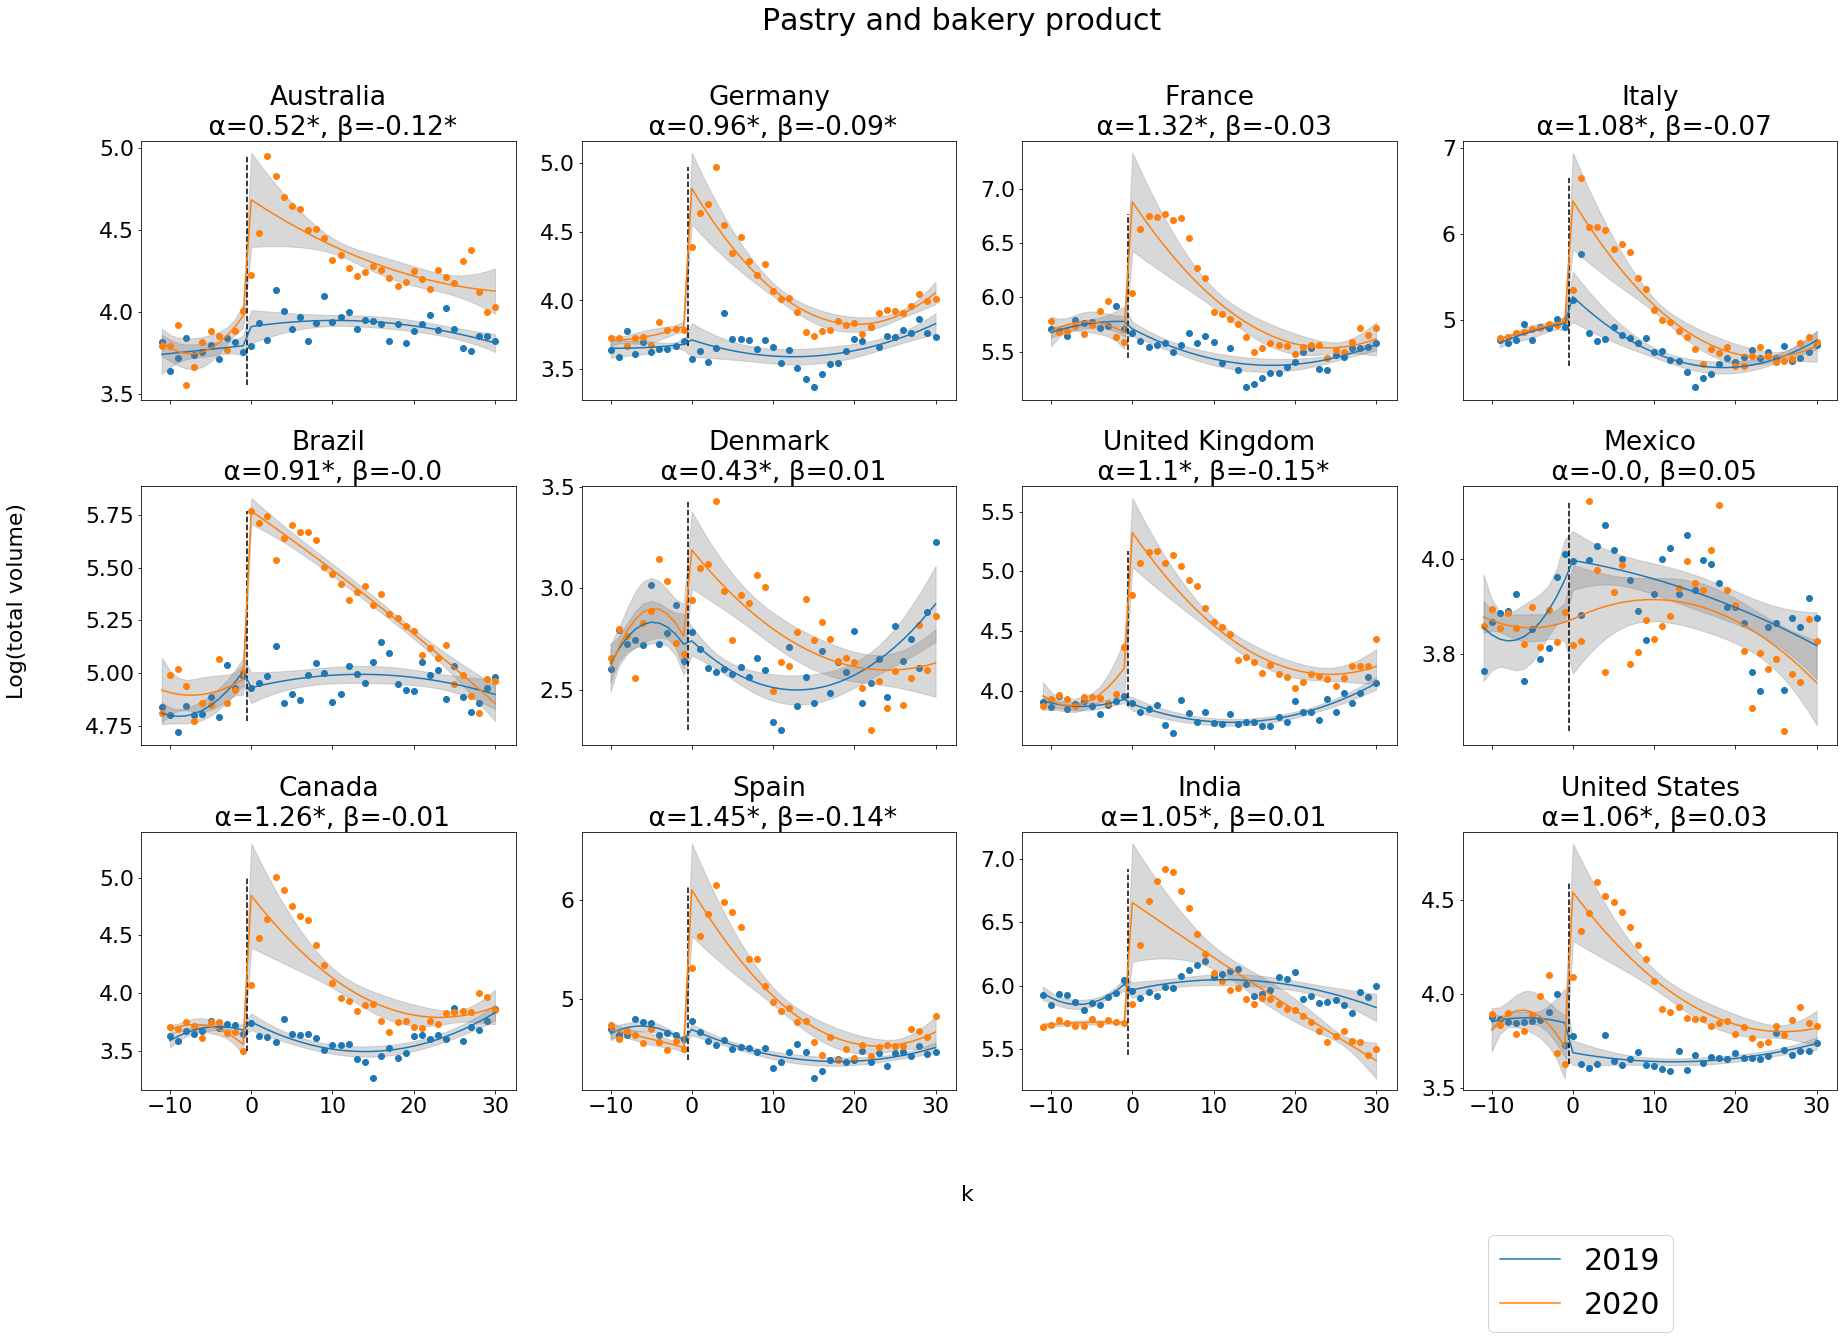

In [45]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

fig, ax = plt.subplots(3,4, figsize= (25,15), sharex = True, sharey = False)

cnt = 0
for country,gr1 in df.groupby('country'):
    for category,gr2 in gr1.groupby('category'):
        if category == 'pastry and bakery product':
            gr2
            sbplt = ax[cnt%3, math.floor(cnt/3)]
            df_temp = gr2.loc[(gr2['k'] >= -k) & (gr2['k'] <= k)].copy()

            df_temp['volume_total'] = df_temp['volume_total'].apply(np.log)

            df_temp = df_temp.loc[df_temp['year'] == '2019']

            sbplt.fill_between(df_temp['k'].values,
                                result_interactions.get_prediction(df_temp).conf_int()[:,0],
                                result_interactions.get_prediction(df_temp).conf_int()[:,1], alpha = 0.3, color = 'gray')

            sbplt.plot(df_temp['k'].values,
                       result_interactions.get_prediction(df_temp).predicted_mean, 
                       color = 'tab:blue', label = '2019')

            sbplt.scatter(df_temp['k'].values,df_temp['volume_total'].values, color = 'tab:blue')


            df_temp = gr2.loc[(gr2['k'] >= -k) & (gr2['k'] <= k)].copy()

            df_temp['volume_total'] = df_temp['volume_total'].apply(np.log)

            df_temp = df_temp.loc[df_temp['year'] == '2020']

            sbplt.fill_between(df_temp['k'].values,
                                result_interactions.get_prediction(df_temp).conf_int()[:,0],
                                result_interactions.get_prediction(df_temp).conf_int()[:,1], alpha = 0.3, color = 'gray')

            sbplt.plot(df_temp['k'].values,
                       result_interactions.get_prediction(df_temp).predicted_mean, 
                       color = 'tab:orange', label = '2020')

            sbplt.scatter(df_temp['k'].values,df_temp['volume_total'].values, color = 'tab:orange')

            
            
            sbplt.vlines(-0.5,(df_temp['volume_total'].values.min()),
                         (df_temp['volume_total'].values.max()), linestyle = '--')
            sbplt.set_xticks([-10,0,10,20,30])
            
            tmp = df_results_interactions.loc[(df_results_interactions['country'] == country)& (df_results_interactions['category'] == category)].iloc[0]
    
            sbplt.set_title(full_names[country]+'\n α='+str(round(tmp['alpha'],2))+(make_star_ste(tmp['alpha'],tmp['alpha_ste']))+
                        ', β='+str(round(tmp['beta'],2)) + (make_star_ste(tmp['beta'],tmp['beta_ste'])))
            
            print(full_names[country]+'\n α='+str(round(tmp['alpha'],2))+(make_star_ste(tmp['alpha'],tmp['alpha_ste'])) + ' (+' +str(round((np.exp(tmp['alpha'])-1)*100,1))+ '%)' +\
                        ',\n β='+str(round(tmp['beta'],2)) + (make_star_ste(tmp['beta'],tmp['beta_ste'])))
            
    cnt+=1

plt.tight_layout()
fig.text(-0.03, 0.5, 'Log(total volume)', va='center', rotation='vertical')
fig.text(0.5, -0.05, 'k', va='center', rotation='horizontal')


fig.suptitle('Pastry and bakery product', position = (0.5,1.05), fontsize= 30)
sbplt.legend(bbox_to_anchor = (0.6,-0.5), fontsize= 30)

plt.savefig(FIGURES_DIR+"example_bakery_fitted.pdf", bbox_inches='tight')

Australia
 α=0.52* (+68.2%), β=-0.12*
Brazil
 α=0.91* (+148.2%), β=-0.0


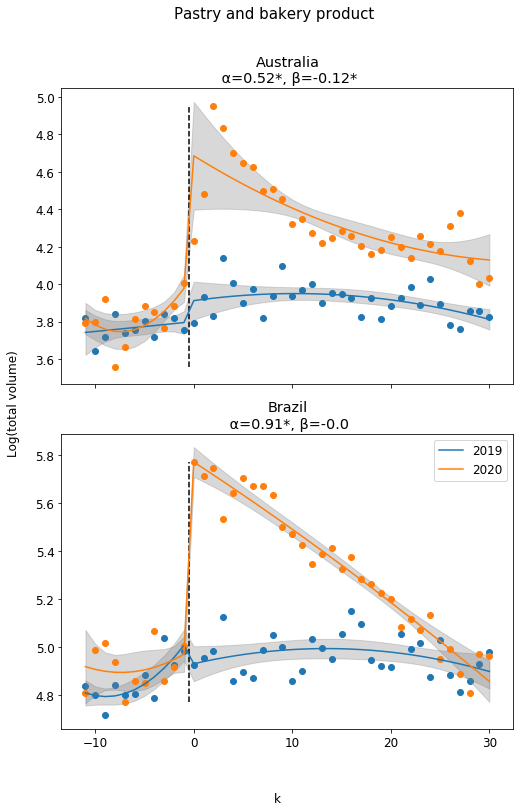

In [46]:
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(2,1, figsize= (7,10), sharex = True, sharey = False)

cnt = 0
for country,gr1 in df.groupby('country'):
    if cnt==2:
        break
    for category,gr2 in gr1.groupby('category'):
        if category == 'pastry and bakery product':
            gr2
            sbplt = ax[cnt]
            df_temp = gr2.loc[(gr2['k'] >= -k) & (gr2['k'] <= k)].copy()

            df_temp['volume_total'] = df_temp['volume_total'].apply(np.log)

            df_temp = df_temp.loc[df_temp['year'] == '2019']

            sbplt.fill_between(df_temp['k'].values,
                                result_interactions.get_prediction(df_temp).conf_int()[:,0],
                                result_interactions.get_prediction(df_temp).conf_int()[:,1], alpha = 0.3, color = 'gray')

            sbplt.plot(df_temp['k'].values,
                       result_interactions.get_prediction(df_temp).predicted_mean, 
                       color = 'tab:blue', label = '2019')

            sbplt.scatter(df_temp['k'].values,df_temp['volume_total'].values, color = 'tab:blue')


            df_temp = gr2.loc[(gr2['k'] >= -k) & (gr2['k'] <= k)].copy()

            df_temp['volume_total'] = df_temp['volume_total'].apply(np.log)

            df_temp = df_temp.loc[df_temp['year'] == '2020']

            sbplt.fill_between(df_temp['k'].values,
                                result_interactions.get_prediction(df_temp).conf_int()[:,0],
                                result_interactions.get_prediction(df_temp).conf_int()[:,1], alpha = 0.3, color = 'gray')

            sbplt.plot(df_temp['k'].values,
                       result_interactions.get_prediction(df_temp).predicted_mean, 
                       color = 'tab:orange', label = '2020')

            sbplt.scatter(df_temp['k'].values,df_temp['volume_total'].values, color = 'tab:orange')

            
            
            sbplt.vlines(-0.5,(df_temp['volume_total'].values.min()),
                         (df_temp['volume_total'].values.max()), linestyle = '--')
            sbplt.set_xticks([-10,0,10,20,30])
            
            tmp = df_results_interactions.loc[(df_results_interactions['country'] == country)& (df_results_interactions['category'] == category)].iloc[0]
    
            sbplt.set_title(full_names[country]+'\n α='+str(round(tmp['alpha'],2))+(make_star_ste(tmp['alpha'],tmp['alpha_ste']))+
                        ', β='+str(round(tmp['beta'],2)) + (make_star_ste(tmp['beta'],tmp['beta_ste'])))
            
            print(full_names[country]+'\n α='+str(round(tmp['alpha'],2))+(make_star_ste(tmp['alpha'],tmp['alpha_ste'])) + ' (+' +str(round((np.exp(tmp['alpha'])-1)*100,1))+ '%)' +\
                        ', β='+str(round(tmp['beta'],2)) + (make_star_ste(tmp['beta'],tmp['beta_ste'])))
            
    cnt+=1

plt.tight_layout()
fig.text(-0.03, 0.5, 'Log(total volume)', va='center', rotation='vertical')
fig.text(0.5, -0.05, 'k', va='center', rotation='horizontal')


fig.suptitle('Pastry and bakery product', position = (0.5,1.05), fontsize= 15)
sbplt.legend( fontsize= 12)

plt.savefig(FIGURES_DIR+"example_annotated.pdf", bbox_inches='tight')